In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import mean_absolute_error, mean_squared_error

import functools
import evidential_deep_learning as edl

tf.__version__

2023-03-30 14:14:52.234894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 14:14:52.448101: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-30 14:14:53.242303: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-30 14:14:53.242378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
#csv_file = '../Dataset/dataset.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
csv_file = '../Dataset/dataset_augmented_new.csv'
dataframe = pd.read_csv(csv_file)
dataframe = dataframe.drop(dataframe.columns[0],axis=1) # remove first column (no information there)
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822,350.23
1,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822,350.23
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140,364.11
3,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140,364.11
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,630.3364,347.10


In [3]:
# Create a target variable
dataframe['target'] = dataframe['R']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140
3,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,630.3364


In [4]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,340.0,0.320588,0.940808,0.0000,0.0000,0.0000,0.0000,4.0000
Pos2,340.0,0.344118,0.957409,0.0000,0.0000,0.0000,0.0000,4.0000
Pos3,340.0,0.314706,0.939664,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,340.0,0.294118,0.886790,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,340.0,0.367647,0.960955,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,340.0,0.326471,0.935630,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,340.0,0.317647,0.949607,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,340.0,0.388235,0.978761,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,340.0,0.388235,0.978761,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,340.0,0.317647,0.949607,0.0000,0.0000,0.0000,0.0000,4.0000


In [5]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,340.0,3.205882e-01,0.940808,0.000000,0.000000,0.000000,0.00000,4.000000
Pos2,340.0,3.441176e-01,0.957409,0.000000,0.000000,0.000000,0.00000,4.000000
Pos3,340.0,3.147059e-01,0.939664,0.000000,0.000000,0.000000,0.00000,4.000000
Pos4,340.0,2.941176e-01,0.886790,0.000000,0.000000,0.000000,0.00000,4.000000
Pos5,340.0,3.676471e-01,0.960955,0.000000,0.000000,0.000000,0.00000,4.000000
Pos6,340.0,3.264706e-01,0.935630,0.000000,0.000000,0.000000,0.00000,4.000000
Pos7,340.0,3.176471e-01,0.949607,0.000000,0.000000,0.000000,0.00000,4.000000
Pos8,340.0,3.882353e-01,0.978761,0.000000,0.000000,0.000000,0.00000,4.000000
Pos9,340.0,3.882353e-01,0.978761,0.000000,0.000000,0.000000,0.00000,4.000000
Pos10,340.0,3.176471e-01,0.949607,0.000000,0.000000,0.000000,0.00000,4.000000


In [6]:
# Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets

### IMPORTANT: Select for normalization
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val, test = np.split(dataset.sample(frac=1), [int(0.8*len(dataset)), int(0.9*len(dataset))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

272 training examples
34 validation examples
34 test examples


In [7]:
# Create an input pipeline using tf.data

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Example: 
batch_size = 1
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of Pos1:', train_features['Pos1'])
print('A batch of targets (R):', label_batch )

Every feature: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'target']
A batch of Pos1: tf.Tensor([[0]], shape=(1, 1), dtype=int64)
A batch of targets (R): tf.Tensor([-0.43203813], shape=(1,), dtype=float64)


/tmp/ipykernel_55901/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2023-03-30 14:15:23.349899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-30 14:15:23.409915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-30 14:15:23.409939: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guid

In [8]:
# Numerical columns preprocessing layer

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [9]:
# Categorical columns preprocessing layer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [10]:
# Create an input pipeline
batch_size = 2
# shuffle is set to False, as it was already done before
#train_ds = df_to_dataset(train, batch_size=batch_size)
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_55901/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_55901/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [11]:
# Preprocess selected features (categorical and numerical)

all_inputs = []
encoded_features = []

# Multi-hot encoding and add the resulting feature inputs to encoded_features
categorical_cols = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 
                    'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 
                    'Pos13', 'Pos14', 'Pos15', 'Pos16']
#categorical_cols= list(train_features.keys())
#categorical_cols = categorical_cols[0:16]
print("Categorical cols: "+str(categorical_cols))
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Normalize numerical features.
""" numeric_cols = ['X', 'Y', 'Z']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

""" numeric_cols = ['target']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

Categorical cols: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


' numeric_cols = [\'target\']\nprint("Numerical cols: "+str(numeric_cols))\nfor header in numeric_cols:\n  numeric_col = tf.keras.Input(shape=(1,), name=header)\n  normalization_layer = get_normalization_layer(header, train_ds)\n  encoded_numeric_col = normalization_layer(numeric_col)\n  all_inputs.append(numeric_col)\n  encoded_features.append(encoded_numeric_col) '

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pos1 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos2 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos3 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos4 (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

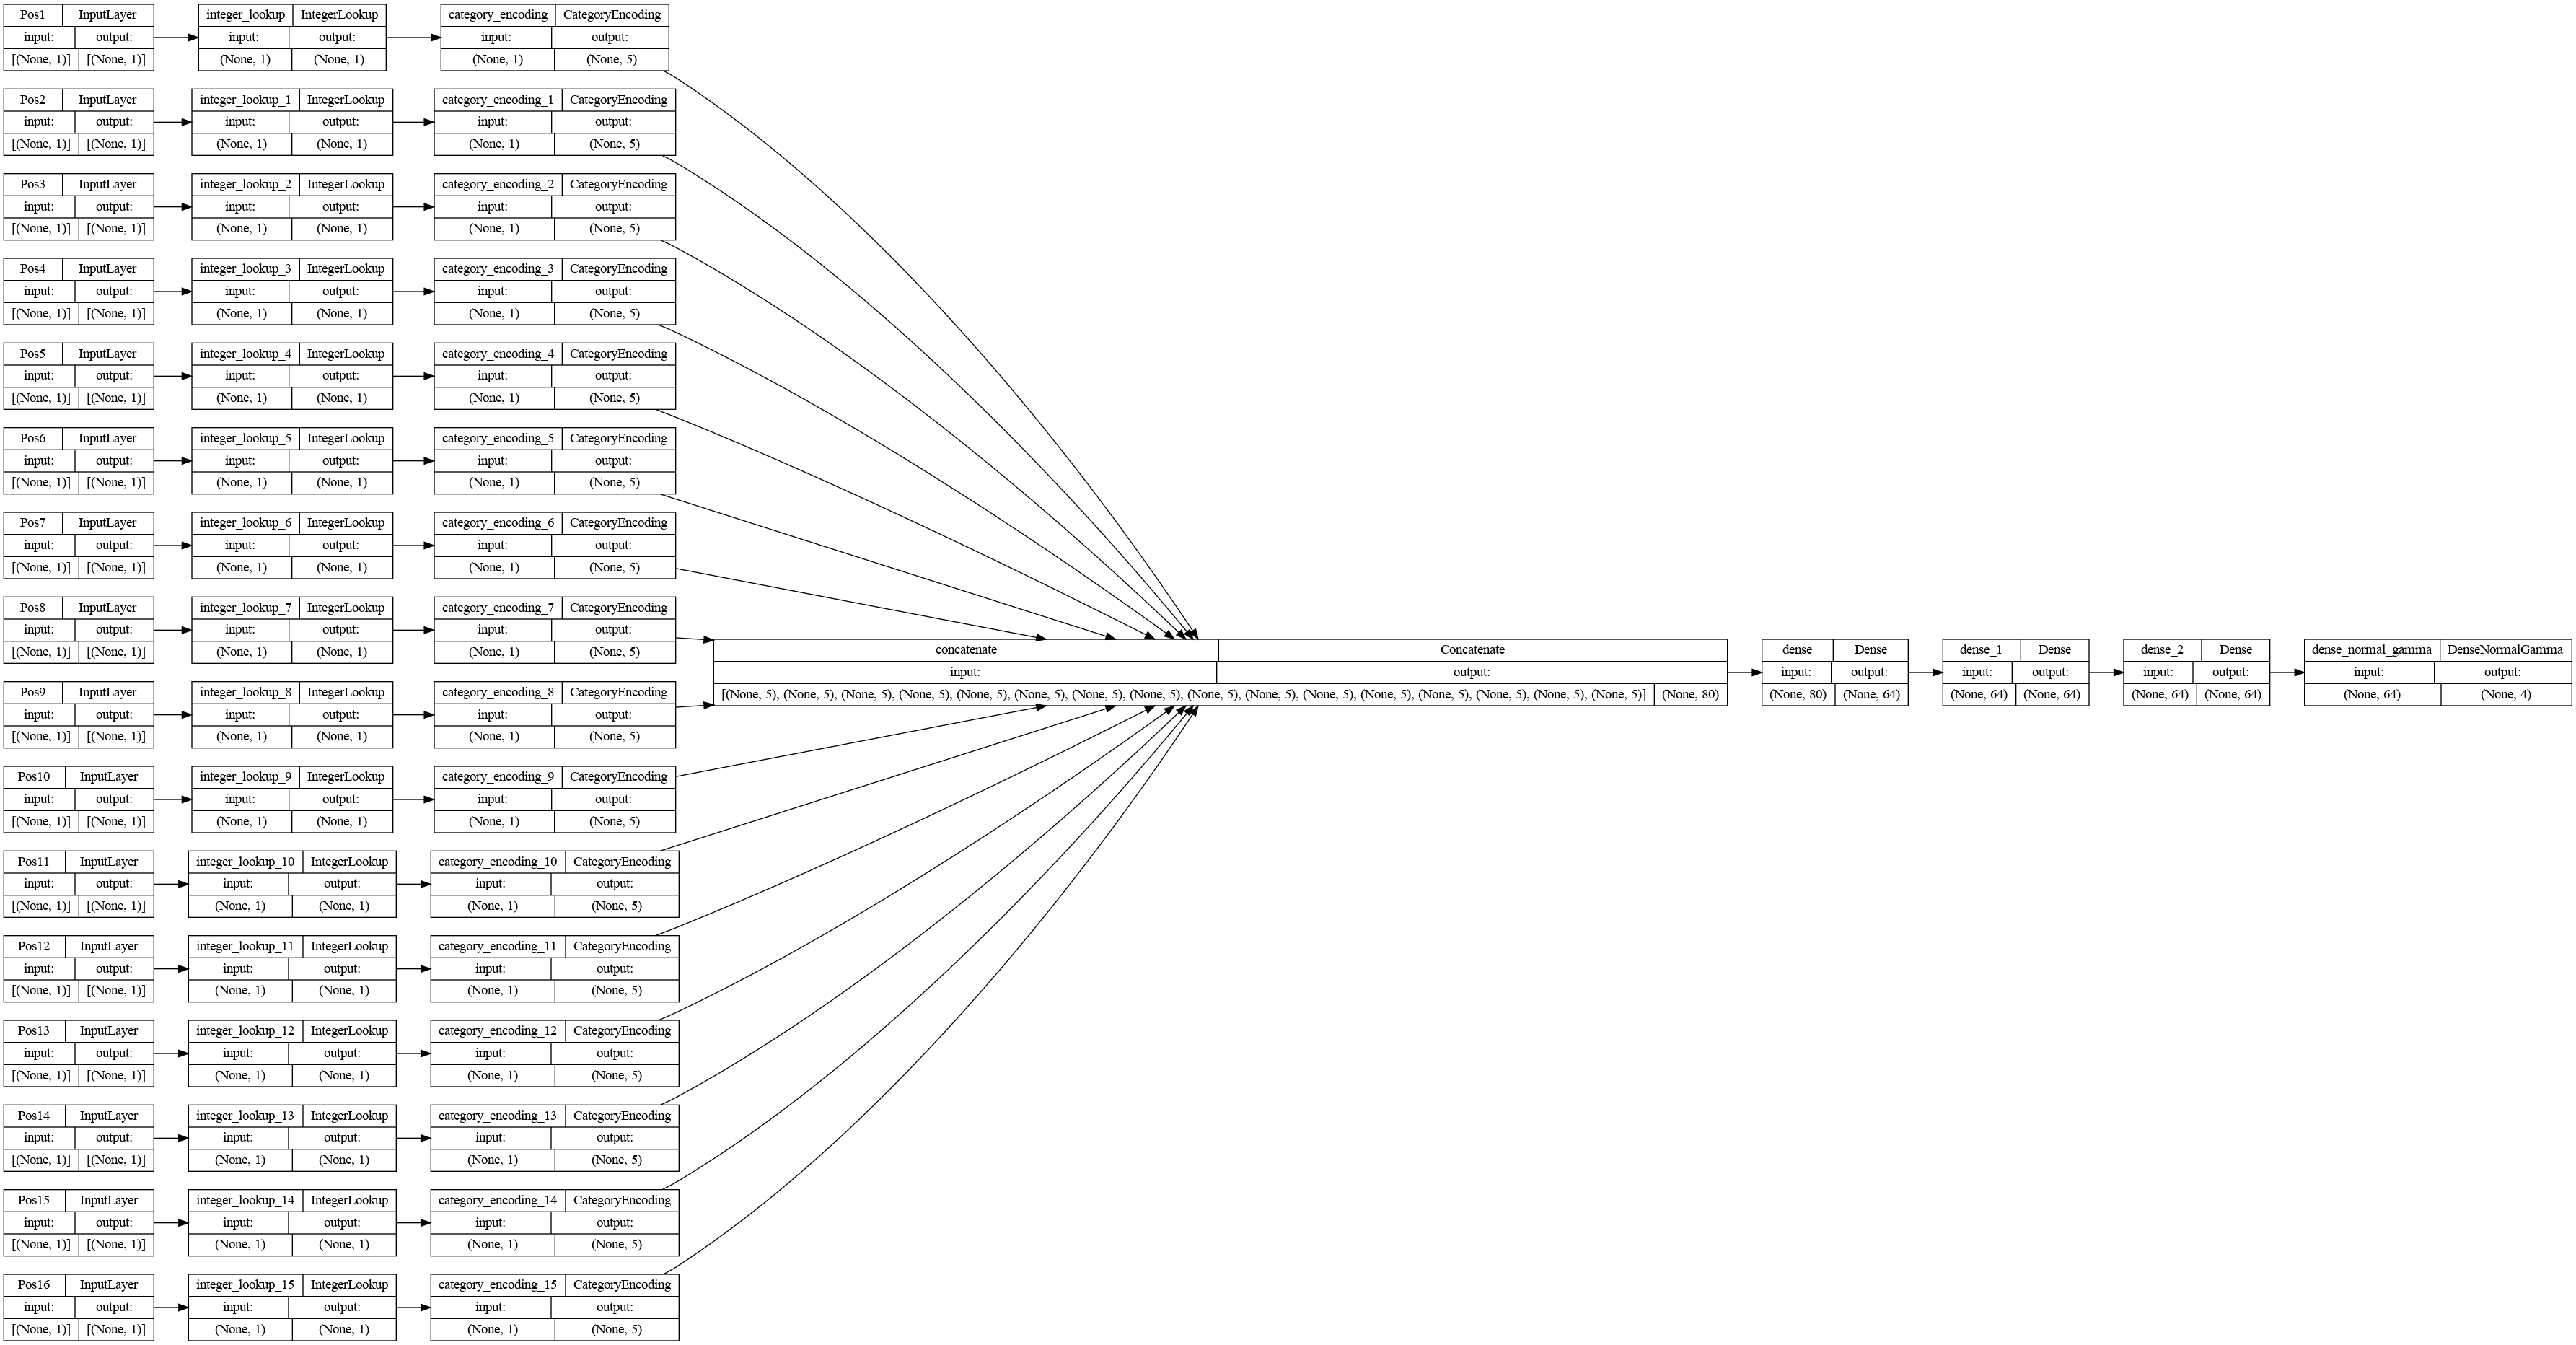

In [12]:
# Create the model architecture
all_features = tf.keras.layers.concatenate(encoded_features)

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

#output = tf.keras.layers.Dense(1)(x)
output = edl.layers.DenseNormalGamma(1)(x)

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #loss=tf.keras.losses.MeanAbsoluteError(),
              loss=EvidentialRegressionLoss,
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [13]:
# Train the model
history = model.fit(train_ds, epochs=300, verbose=2, validation_data=val_ds)


Epoch 1/300


/home/alfonso/Work/UGR/Calculations/Helicenes_GNNs/Helicenes_venv/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


136/136 - 2s - loss: 1.4871 - val_loss: 1.3995 - 2s/epoch - 12ms/step
Epoch 2/300
136/136 - 0s - loss: 1.4498 - val_loss: 1.3814 - 148ms/epoch - 1ms/step
Epoch 3/300
136/136 - 0s - loss: 1.4122 - val_loss: 1.3587 - 144ms/epoch - 1ms/step
Epoch 4/300
136/136 - 0s - loss: 1.3640 - val_loss: 1.3172 - 145ms/epoch - 1ms/step
Epoch 5/300
136/136 - 0s - loss: 1.2971 - val_loss: 1.2709 - 143ms/epoch - 1ms/step
Epoch 6/300
136/136 - 0s - loss: 1.2126 - val_loss: 1.2153 - 143ms/epoch - 1ms/step
Epoch 7/300
136/136 - 0s - loss: 1.1034 - val_loss: 1.1491 - 145ms/epoch - 1ms/step
Epoch 8/300
136/136 - 0s - loss: 0.9802 - val_loss: 1.0773 - 145ms/epoch - 1ms/step
Epoch 9/300
136/136 - 0s - loss: 0.8540 - val_loss: 1.0257 - 145ms/epoch - 1ms/step
Epoch 10/300
136/136 - 0s - loss: 0.7371 - val_loss: 0.9989 - 145ms/epoch - 1ms/step
Epoch 11/300
136/136 - 0s - loss: 0.6312 - val_loss: 0.9865 - 145ms/epoch - 1ms/step
Epoch 12/300
136/136 - 0s - loss: 0.5351 - val_loss: 0.9857 - 142ms/epoch - 1ms/step
Epo

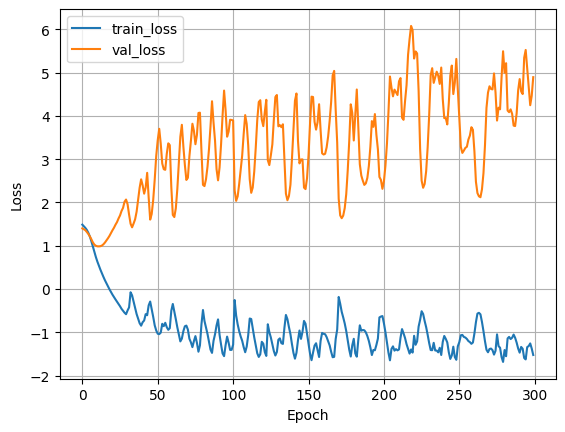

In [14]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [71]:
def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=8)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

def plot_PredvsTrue_error(y_true, y_pred, y_error):

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    plt.errorbar(y_true, y_pred, yerr=y_error, label='Pred',fmt="o")
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.xlim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.ylim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.show() 

""" def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    #plt.scatter(y_true,mu,color="blue",label="Pred",s=6)
    plt.errorbar(y_true, mu, yerr=5*var, label='Pred',fmt="o")
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.xlim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.ylim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.show()     """

' def plot_PredvsTrue(y_true, y_pred, n_stds=2):\n\n    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)\n    mu = mu[:, 0]\n    var = np.sqrt(beta / (v * (alpha - 1)))\n    var = np.minimum(var, 1e3)[:, 0]  # for visualization\n    #y_true = y_true[:,0]\n\n    plt.figure(figsize=(5, 5), dpi=200)\n    p1 = min(y_true)\n    p2 = max(y_true)\n    #p1 = 0\n    #p2 = 64\n    #p1 = max(max(y_pred), max(y_true))\n    #p2 = min(min(y_pred), min(y_true))\n    plt.plot([p1, p2], [p1, p2], \'r--\', label="True")\n    #plt.plot(y_true, y_true, \'r--\', zorder=2, label="True")\n    #plt.plot(y_true, mu, color=\'#007cab\', zorder=3, label="Pred")\n    #plt.scatter(y_true,mu,color="blue",label="Pred",s=6)\n    plt.errorbar(y_true, mu, yerr=5*var, label=\'Pred\',fmt="o")\n    #plt.gca().set_xlim(-200, 200)\n    #plt.gca().set_ylim(-200, 200)\n    #plt.gca().set_xlim(0.8*p1, 1.1*p2)\n    #plt.gca().set_ylim(0.9*p1, 1.1*p2)\n    plt.xlabel(\'True\',fontsize=15)\n    plt.ylabel(\'Pred\',fontsize=15)\n 

17/17 [==============================] - 0s 880us/step
(34, 4)
(34,)
(34,)


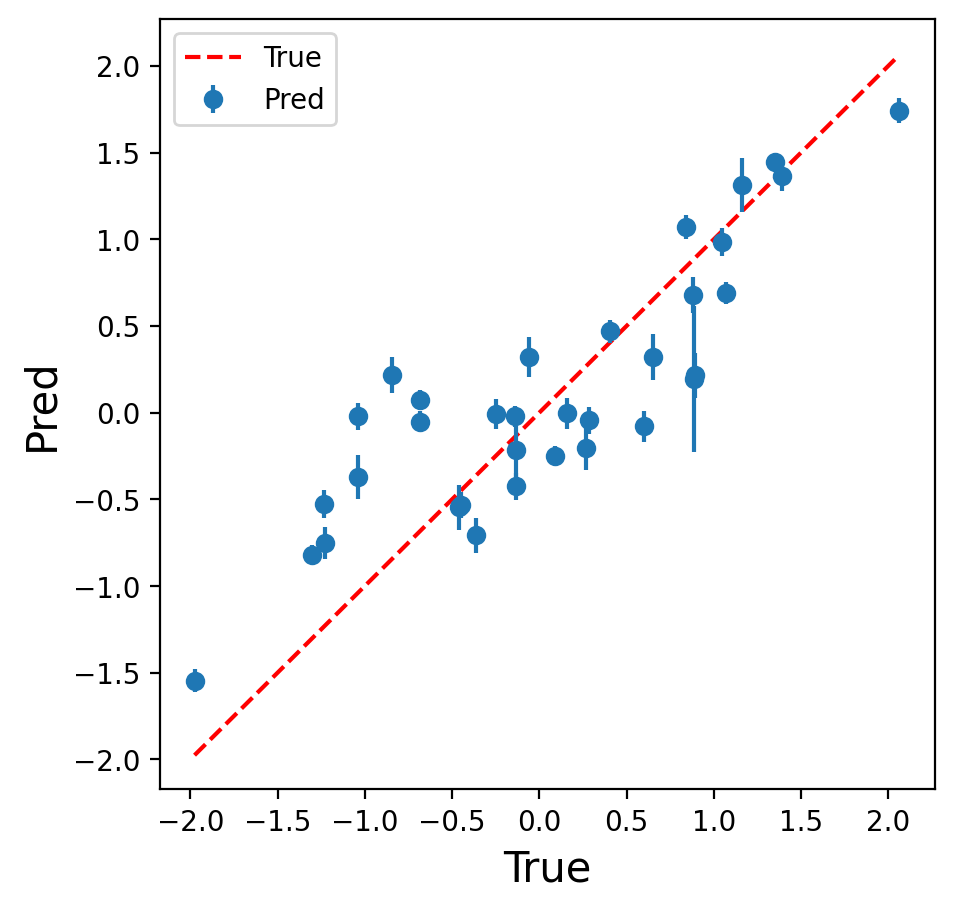

Test MAE: 0.3841280733518817


In [75]:
# Pred vs True values on test set 

v_pred = model.predict(test_ds)
print(v_pred.shape)
mu, v, alpha, beta = tf.split(v_pred, 4, axis=-1)
y_pred = mu[:, 0]
var = np.sqrt(beta / (v * (alpha - 1)))
y_error = 3*var[:,0]
y_true = np.zeros(len(test['target']))
y_true[:] = test['target']

print(y_true.shape)
print(y_pred.shape)

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, y_error)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

136/136 [==============================] - 0s 889us/step
(272, 4)
(272,)
(272,)


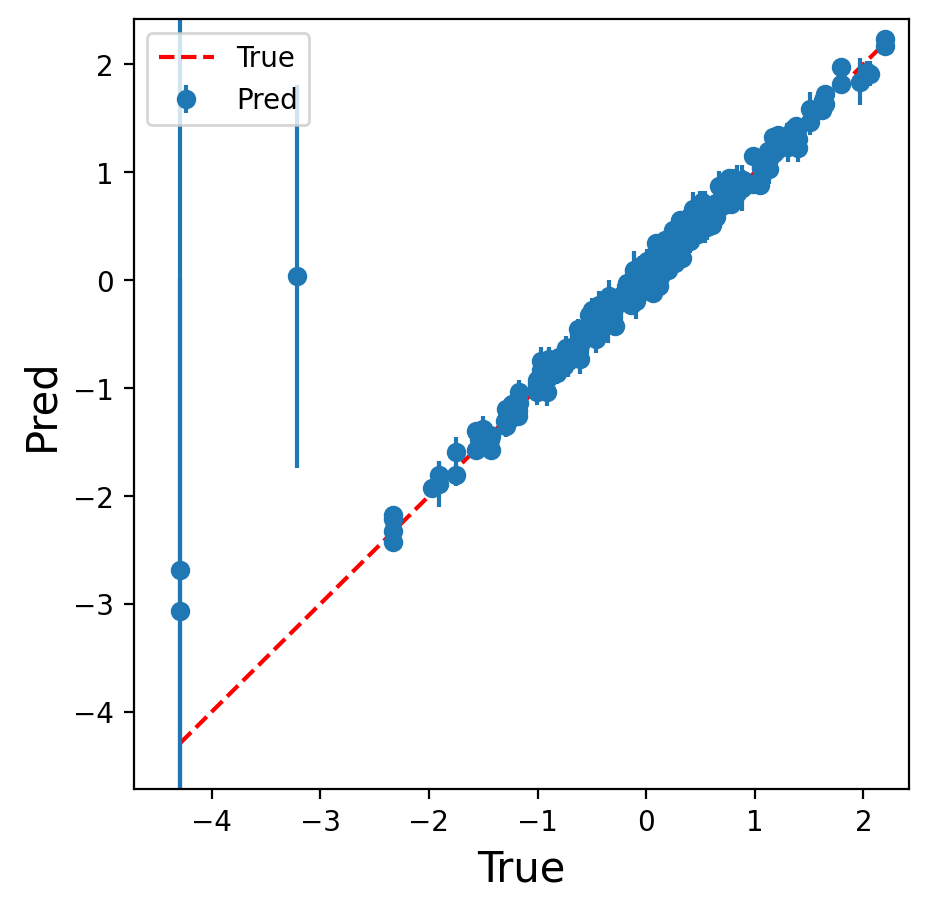

Train MAE: 0.0949073096066748


In [85]:
# Pred vs True values on training set 

v_pred = model.predict(train_ds)
print(v_pred.shape)

y_true = np.zeros(len(train['target']))
y_true[:] = train['target']
mu, v, alpha, beta = tf.split(v_pred, 4, axis=-1)
y_pred = mu[:, 0]
var = np.sqrt(beta / (v * (alpha - 1)))
y_error = 3*var[:,0]

print(y_true.shape)
print(y_pred.shape)

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, y_error)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae))

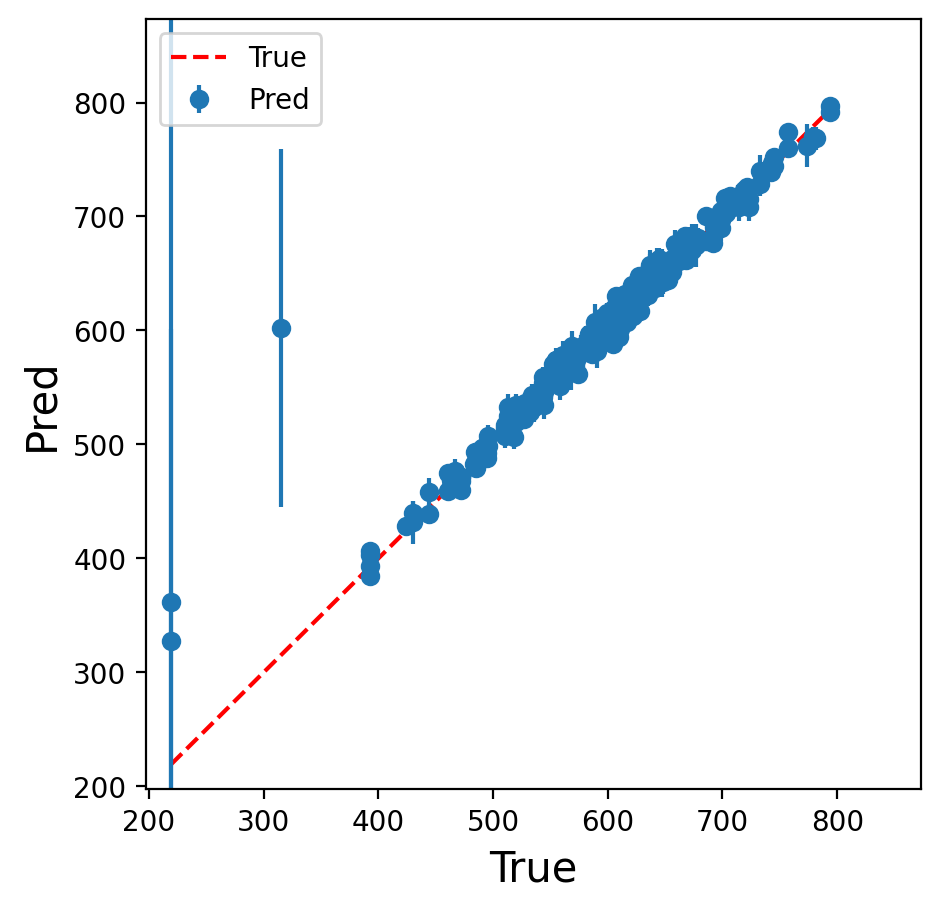

Train MAE (non-normalized): 8.404624986715874


In [87]:
# Evaluate the model with non-normalized units

y_true_units = y_true * R_std + R_mean
y_pred_units = y_pred * R_std + R_mean
y_error_units = y_error * R_std

#plot_PredvsTrue(y_true_units, y_pred_units)
plot_PredvsTrue_error(y_true_units, y_pred_units, y_error_units)

test_mae = mean_absolute_error(y_true_units,y_pred_units)
print("Train MAE (non-normalized): "+str(test_mae))

In [65]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

INFO:tensorflow:Assets written to: R_model_good_medium/assets


INFO:tensorflow:Assets written to: R_model_good_medium/assets


17/17 [==============================] - 0s 1ms/step


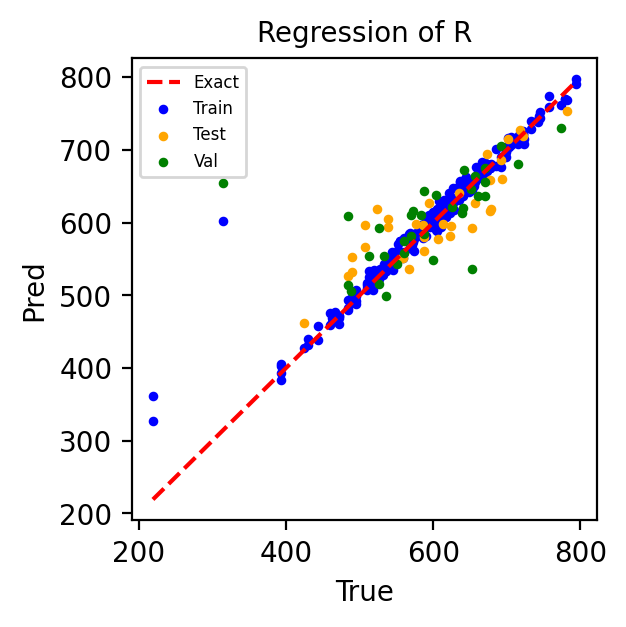

train MAE (non-normalized): 8.404624986715874
test MAE (non-normalized): 34.01690674977023
val MAE (non-normalized): 39.77519260253906


In [89]:
# Evaluate the model with non-normalized units on the whole dataset

v_pred_test = model.predict(test_ds)
mu, v, alpha, beta = tf.split(v_pred_test, 4, axis=-1)
y_pred_test = mu[:, 0]
y_true_test = np.zeros(len(test['target']))
y_true_test[:] = test['target']

v_pred_train = model.predict(train_ds)
mu, v, alpha, beta = tf.split(v_pred_train, 4, axis=-1)
y_pred_train = mu[:, 0]
y_true_train = np.zeros(len(train['target']))
y_true_train[:] = train['target']

v_pred_val = model.predict(val_ds)
mu, v, alpha, beta = tf.split(v_pred_val, 4, axis=-1)
y_pred_val = mu[:, 0]
y_true_val = np.zeros(len(val['target']))
y_true_val[:] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
#y_true_test = y_true_test.ravel()
#y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
#y_true_train = y_true_train.ravel()
#y_pred_train = y_pred_train.ravel()

y_true_val = y_true_val * R_std + R_mean
y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
val_mae = mean_absolute_error(y_true_val,y_pred_val)
print("val MAE (non-normalized): "+str(val_mae))

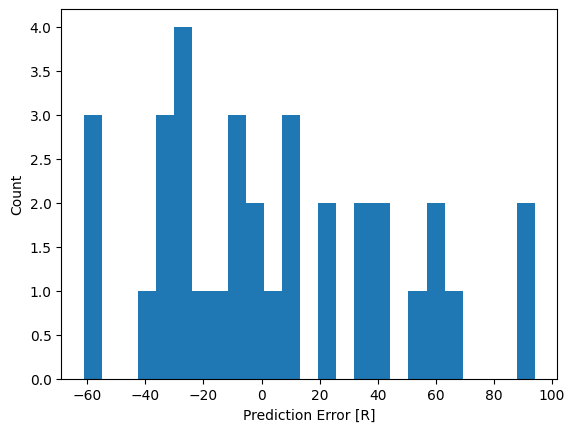

In [90]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


In [91]:
y_pred = np.concatenate((y_pred_train,y_pred_test,y_pred_val))
y_true = np.concatenate((y_true_train,y_true_test,y_true_val))
#print(y_true.shape)
#print(y_pred.shape)
#print(y_true)
#print(y_pred)
y_true = y_true.ravel()
y_pred = y_pred.ravel()
#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

# explore data

data = dataset.to_numpy()

#print()
print("Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)")

error_nhalogens = np.zeros(4)
num_nhalogens = np.zeros(4)
error_halogentype = np.zeros(4)
num_halogentype = np.zeros(4)

for i in range(len(y_pred)):
    diff = abs(y_pred[i]-y_true[i])
    x_data = data[i,0:15]
    n_halogens = np.count_nonzero(x_data)
    #print(data[i,0:15])
    #print(n_halogens)

    error_nhalogens[n_halogens-1] = error_nhalogens[n_halogens-1] + diff
    num_nhalogens[n_halogens-1] = num_nhalogens[n_halogens-1] + 1

    print(str(i)+"  "+str(n_halogens)+"  "+str(y_true[i])+"  "+str(y_pred[i])+"  "+str(diff))


error_nhalogens[:] = error_nhalogens[:] / num_nhalogens[:]
print()
print("Mean Absolute Error (MAE) according to nº halogens: 1 halogen, 2 halogens, 3 halogens, 4 halogens")
print(error_nhalogens)

Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)
0  2  698.5759  697.2428  1.333102148437547
1  2  599.2599  601.1085  1.848620507812484
2  3  471.662  471.72815  0.06614941406252228
3  1  510.2321  509.83426  0.39784096679687764
4  2  624.2209  626.2604  2.0394759765624713
5  2  626.8518  627.3232  0.47138115234372435
6  3  558.1551  557.6485  0.5066014648436976
7  2  560.7961  559.15497  1.641131738281274
8  2  547.925  555.79675  7.8717529296875455
9  1  492.0714  490.84552  1.2258799804687328
10  1  666.3543  665.03485  1.3194489257812165
11  3  556.374  554.7416  1.6324228515625236
12  3  721.4312  719.8302  1.6009998046874898
13  1  655.8208  650.88336  4.937438183593713
14  1  536.491  536.92126  0.43026464843751455
15  1  773.7501  761.9739  11.776223046874975
16  2  646.6411  651.96594  5.324842382812449
17  2  583.3478  595.8975  12.549721972656243
18  2  556.374  556.2204  0.15360205078127365
19  2  651.5868  648.16516  3.4216388671875393
20  2  523.8055  528.3349  4